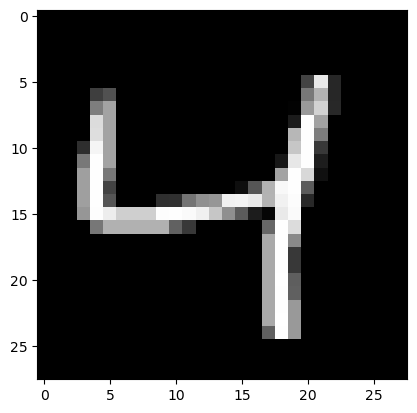

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")

plt.imshow(x_train[2],cmap='gray');

In [2]:
import numpy as np
def sigmoid(x):
    
    # Numerically stable sigmoid function based on
    # http://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/

    x = np.clip(x, -500, 500)  # We get an overflow warning without this

    return np.where(
        x >= 0,
        1 / (1 + np.exp(-x)),
        np.exp(x) / (1 + np.exp(x))
    )


def dsigmoid(x):  # Derivative of sigmoid
    return sigmoid(x) * (1 - sigmoid(x))

def softmax(x):
    # Numerically stable softmax based on (same source as sigmoid)
    # http://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
    b = x.max()
    y = np.exp(x - b)
    return y / y.sum()

def cross_entropy_loss(y, yHat):
    return -np.sum(y * np.log(yHat))

def integer_to_one_hot(x, max):
    # x: integer to convert to one hot encoding
    # max: the size of the one hot encoded array
    result = np.zeros(10)
    result[x] = 1
    return result


In [3]:
import math

# Initialize weights of each layer with a normal distribution of mean 0 and
# standard deviation 1/sqrt(n), where n is the number of inputs.
# This means the weighted input will be a random variable itself with mean
# 0 and standard deviation close to 1 (if biases are initialized as 0, standard
# deviation will be exactly 1)

from numpy.random import default_rng

rng = default_rng(80085)

# Q1. Fill initialization code here.
# ...

layers = [784, 32, 32, 10]
weights = []
biases = []

for i in range(3):
    
    n_in, n_out = layers[i], layers[i + 1]
    w = rng.normal(0, (1 / math.sqrt(n_in)), (n_in, n_out))
    weights.append(w)

    b = np.zeros((1,n_out))
    biases.append(b)


In [4]:
def feed_forward_sample(sample, label):
    """
    Forward pass through the neural network.
    Inputs:
      sample: 1D numpy array. The input sample (an MNIST digit).
      label: An integer from 0 to 9.

    Returns: the cross entropy loss, most likely class
    """
    
    # Q2. Fill code here.
    # ...
    
    activation = sample.flatten()
    
    for index, weight in enumerate(weights):
        
        z = np.matmul(activation,weight)+biases[index] # z = wx+b
        if index < len(weights)-1:
            activation = sigmoid(z)  # z' = sigmoid(z)
        else:
            activation = softmax(z)  # z' = softmax(z) 

    y = integer_to_one_hot(label,10)  # True label
    
    loss = cross_entropy_loss(y,activation) 
    
    prediction = np.argmax(activation)
    one_hot_prediction = integer_to_one_hot(prediction,10)

    return loss, one_hot_prediction 


In [5]:
def feed_forward_dataset(x, y):
    losses = np.empty(x.shape[0])
    one_hot_guesses = np.empty((x.shape[0], 10))
    # ...
    # Q2. Fill code here to calculate losses, one_hot_guesses
    # ...

    for i in range(x.shape[0]):
        sample = x[i]
        label = y[i]
        L, P = feed_forward_sample(sample, label)
        losses[i] = L
        one_hot_guesses[i] = P

    y_one_hot = np.zeros((y.size, 10))
    y_one_hot[np.arange(y.size), y] = 1

    correct_guesses = np.sum(y_one_hot * one_hot_guesses)
    correct_guess_percent = format((correct_guesses / y.shape[0]) * 100, ".2f")

    print("\nAverage loss:", np.round(np.average(losses), decimals=2))
    print("Accuracy (# of correct guesses):", correct_guesses, "/", y.shape[0], "(", correct_guess_percent, "%)")


def feed_forward_training_data():
    print("Feeding forward all training data...")
    feed_forward_dataset(x_train, y_train)
    print("")


def feed_forward_test_data():
    print("Feeding forward all test data...")
    feed_forward_dataset(x_test, y_test)
    print("")

In [6]:
feed_forward_test_data()

Feeding forward all test data...

Average loss: 2.37
Accuracy (# of correct guesses): 880.0 / 10000 ( 8.80 %)



In [7]:
def train_one_sample(sample, y, learning_rate=0.003): 
    a = np.reshape(sample,(1,28*28))
      
    # We will store each layer's activations to calculate gradient
    
    # Forward pass
    activations = []
    num_layers = 3
    weight_gradients = []
    bias_gradients = []
    numclasses = 10
    
    u1 = np.dot(a,weights[0]) + biases[0]
    z1 = sigmoid(u1)  # hidden layer1
    activations.append(z1)
    
    u2 = np.dot(z1,weights[1]) + biases[1]
    z2 = sigmoid(u2)  # hidden layer2
    activations.append(z2)
    
    u3 = np.dot(z2,weights[2]) + biases[2]
    yhat = softmax(u3)  # hidden layer3
    activations.append(yhat)
    
    #activation[i][j] indicate the activated result of j_th neuron in the i_th layer
        
    # Q3. This should be the same as what you did in feed_forward_sample above.
    # ...    
    
    # Loss Calculation
    yvector = integer_to_one_hot(y,numclasses)
    loss = cross_entropy_loss(yvector,yhat)
    
    #Prediction
    pred = np.argmax(yhat)
    one_hot_guess = integer_to_one_hot(pred,10)
        
    # Backward pass

    # Q3. Implement backpropagation by backward-stepping gradients through each layer.
    # You may need to be careful to make sure your Jacobian matrices are the right shape.
    # At the end, you should get two vectors: weight_gradients and bias_gradients.
    # ...
    
    # Update weights & biases based on your calculated gradient
    
    du3 = activations[2]-yvector  # hidden layer3
    dW3 = activations[1].T.dot(du3)
    db3 = du3
    
    dz2 = du3.dot(weights[2].T)  # hidden layer2
    dW2 = activations[0].T.dot(np.multiply(dz2,dsigmoid(u2)))
    db2 = np.multiply(dz2,dsigmoid(u2))
    
    dz1 = np.multiply(dz2.dot(weights[1].T),dsigmoid(u2))  # hidden layer1
    dW1 = a.T.dot(np.multiply(dz1,dsigmoid(u1)))
    db1 = np.multiply(dz1,dsigmoid(u1))
                                       
    weight_gradients.append(dW1)
    weight_gradients.append(dW2)
    weight_gradients.append(dW3)
    bias_gradients.append(db1)
    bias_gradients.append(db2)
    bias_gradients.append(db3)
    
    for i in range(num_layers):
        weights[i] -= weight_gradients[i] * learning_rate 
        biases[i] -= bias_gradients[i].flatten() * learning_rate


In [9]:
def train_one_epoch(x, y, learning_rate=0.0005):
    
    # Q4. Write the training loop over the epoch here.
    # ...
    for i in range(x.shape[0]):
        if i==0 or ((i+1)%10000 == 0):
            percentage = (i+1)/x_train.shape[0]*100
            print('Training Percentage: {:.3f}'.format(percentage))
            
        train_one_sample(x[i],y[i],learning_rate)
    print("")
            
def test_and_train():
    train_one_epoch(x_train,y_train)
    feed_forward_test_data()


for i in range(3): 
    print('Epoch {} is running'.format(i+1))
    test_and_train()
    
print('{} epoches have been completed. '.format(i+1))


Epoch 1 is running
Training Percentage: 0.002
Training Percentage: 16.667
Training Percentage: 33.333
Training Percentage: 50.000
Training Percentage: 66.667
Training Percentage: 83.333
Training Percentage: 100.000

Feeding forward all test data...

Average loss: 0.49
Accuracy (# of correct guesses): 8686.0 / 10000 ( 86.86 %)

Epoch 2 is running
Training Percentage: 0.002
Training Percentage: 16.667
Training Percentage: 33.333
Training Percentage: 50.000
Training Percentage: 66.667
Training Percentage: 83.333
Training Percentage: 100.000

Feeding forward all test data...

Average loss: 0.45
Accuracy (# of correct guesses): 8684.0 / 10000 ( 86.84 %)

Epoch 3 is running
Training Percentage: 0.002
Training Percentage: 16.667
Training Percentage: 33.333
Training Percentage: 50.000
Training Percentage: 66.667
Training Percentage: 83.333
Training Percentage: 100.000

Feeding forward all test data...

Average loss: 0.46
Accuracy (# of correct guesses): 8627.0 / 10000 ( 86.27 %)

3 epoches hav